In [42]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt

'''#import plotly for interactive chart
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='richwolff', api_key='v0qPC120X33yPvAMDQXi')
from plotly.graph_objs import * '''

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from collections import defaultdict
%matplotlib inline

<h2>Load books into dataframe</h2>

In [43]:
d = defaultdict(list)

strtofind = r'";"'
with open('../data/raw/BX-Books.csv','r',encoding='8859') as file:
    for i,line in enumerate(file):
        d[i] = re.sub(strtofind,'||',line.replace('&amp;','&')).replace('"','').replace('\n','').split('||')
        
books_df = pd.DataFrame(data=list(d.values())[1:],index=list(d.keys())[1:],columns=d[0])
del d

In [44]:
## https://en.wikipedia.org/wiki/List_of_ISBN_identifier_groups
def book_lan_nationality(x):
    if x in ('0','1'):
        return 'English'
    elif not x in ('2','3','4','5','7'):
        return 'Other'
    elif x == '2':
        return 'French'
    elif x == '3':
        return 'German'
    elif x == '4':
        return 'Japan'
    elif x == '5': 
        return 'former USSR'
    elif x == '7': 
        return 'China'
    return None

books_df['origin'] = books_df['ISBN'].str.slice(0,1).apply(book_lan_nationality)
books_df['1st_3_publisher'] =books_df['ISBN'].str.slice(0,4).apply(lambda x: x[1:4] if x[0] in ('0','1','2','3','4','5','7') else 'Other')
books_df.sort_values(['origin','1st_3_publisher']).head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,origin,1st_3_publisher
243630,706400402X,Oriental Rugs and Carpets,Stanley Reed,0,Octopus Books,http://images.amazon.com/images/P/706400402X.0...,http://images.amazon.com/images/P/706400402X.0...,http://images.amazon.com/images/P/706400402X.0...,China,064
79353,7108009153,Zi ben zhu yi yu er shi yi shi ji,Ray Huang,1997,Jing xiao Xin hua shu dian,http://images.amazon.com/images/P/7108009153.0...,http://images.amazon.com/images/P/7108009153.0...,http://images.amazon.com/images/P/7108009153.0...,China,108
226475,710800982X,Wan li shi wu nian (Huang Renyu zuo pin xi lie),Ray Huang,1997,Jing xiao Xin hua shu dian,http://images.amazon.com/images/P/710800982X.0...,http://images.amazon.com/images/P/710800982X.0...,http://images.amazon.com/images/P/710800982X.0...,China,108
19579,7119020412,Tales From Ancient China's Imperial Harem,Yuan Yang,1998,Foreign Languages Press,http://images.amazon.com/images/P/7119020412.0...,http://images.amazon.com/images/P/7119020412.0...,http://images.amazon.com/images/P/7119020412.0...,China,119
125185,711900557X,"The pocket interpreter, Chinese",Lydia Chen,1988,Foreign Languages Press,http://images.amazon.com/images/P/711900557X.0...,http://images.amazon.com/images/P/711900557X.0...,http://images.amazon.com/images/P/711900557X.0...,China,119


<H2> Load Users Into DF </H2>

In [45]:
## Load users file and display first 5 rows
users_df = pd.read_csv('../data/raw/BX-Users.csv',sep=';',encoding='8859')
users_df.tail(5)

,User-ID,Location,Age
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN
278857,278858,"dublin, n/a, ireland",NaN


<h3>There may be similarities of books read within certain age ranges. I'll create a category of age ranges to see if we can increase the accuracy of our model</h3>

(0, 100)

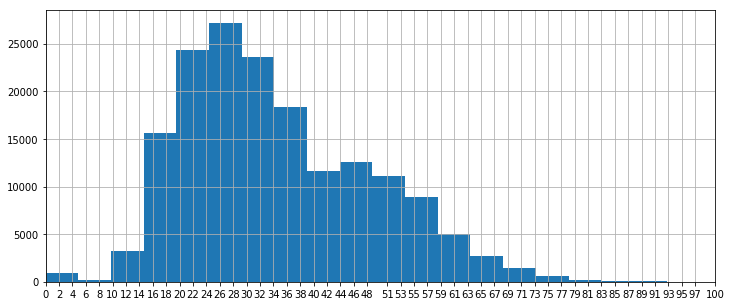

In [46]:
users_df['Age'].hist(bins=50,figsize=(12,5))
plt.xticks(np.linspace(0,100,50,dtype=np.int));
plt.xlim(0,100)

Age Ranges:
<ul>
<LI>LT 16</LI><LI>16 - 20</LI><LI>20 - 30</LI><LI>30 - 40</LI><LI>40 - 55</LI><LI>55+</LI>
</UL>

In [47]:
def age_range(x):
    if x < 16:
        return 'LT 16'
    elif x >=16 and x < 20:
        return '16-20'
    elif x >=20 and  x < 30:
        return '20-30'
    elif x >=30 and x < 40:
        return '20-40'
    elif x >=40 and x < 55:
        return '40-55'
    elif x >= 55:
        return 'GT 55'
    else:
        return 'Unknown'
users_df['age_range'] = users_df['Age'].apply(age_range)

<h2>Load User Ratings Of Books</h2>

In [48]:
ratings_df = pd.read_csv('../data/raw/BX-Book-Ratings.csv',sep=';',encoding='8859',dtype={'Book-Rating':np.int}).sort_values('User-ID')
ratings_df.head()

,User-ID,ISBN,Book-Rating
9561,2,0195153448,0
9562,7,034542252,0
9572,8,0771025661,0
9580,8,1881320189,7
9579,8,1575663937,6


In [49]:
## Join user and book data to ratings data
ratings = ratings_df.set_index('User-ID').join(users_df.set_index('User-ID')).reset_index().set_index('ISBN').join(books_df.set_index('ISBN'))

## Split out users from the USA
us_ratings = ratings[(ratings['Location'].str.lower().str.contains('usa')) | (ratings['Location'].str.lower().str.contains('states'))].reset_index()
us_ratings.head()

,ISBN,User-ID,Book-Rating,Location,Age,age_range,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,origin,1st_3_publisher
0,0375404120,266865,0,"reston, virginia, usa",33.0,20-40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,)440206529,238681,0,"milford, ohio, usa",NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,)452273056,111422,8,"avon, massachusetts, usa",59.0,GT 55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,*0515128325,190925,0,"hobe sound, florida, usa",51.0,40-55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/8741060773,52796,9,"sumner, iowa, usa",0.0,LT 16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Drop books that have only been read once. These can not be used for good recommendations</h2>

In [50]:
# How many times a book must have been read to keep it in ratings
min_book_read_count = 2

isbn_val_counts = us_ratings['ISBN'].value_counts()
books_to_keep = set(isbn_val_counts[isbn_val_counts>=min_book_read_count].index)

filtered_us_ratings = us_ratings[us_ratings['ISBN'].isin(books_to_keep)]

<h2>Split data into training and test sets</h2>

In [51]:
ratings_us_training,ratings_us_test = train_test_split(filtered_us_ratings,test_size=.20,random_state=21)

<h2>Insert data into graph data structure</h2>

In [52]:
import datetime as dt
user_nodes = set(ratings_us_training['User-ID'].unique())
book_nodes = set(ratings_us_training['ISBN'].unique())

# Build the graph structure from pandas data frame
G = nx.from_pandas_edgelist(ratings_us_training,'User-ID','ISBN',['Book-Rating'])

# Compute DCS
dcs = nx.bipartite.degree_centrality(G,user_nodes)

# Add Meta Data
for i,row in ratings_us_training.iterrows():
    user_node = G.node[row['User-ID']]
    book_node = G.node[row['ISBN']]
    
    user_node['age_range'] = row['age_range']
    user_node['Location'] = row['Location']
    user_node['bipartite'] = 'user'
    user_node['dcs'] = dcs[row['User-ID']]
    
    book_node['origin'] = row['origin']
    book_node['isbn_1st_3'] = row['1st_3_publisher']
    book_node['bipartite'] = 'book'
    book_node['Book-Title'] = row['Book-Title']
    book_node['Book-Author'] = row['Book-Author']
    book_node['Publisher'] = row['Publisher']
    book_node['Publication_Year'] = row['Year-Of-Publication']
    book_node['dcs'] = dcs[row['ISBN']]

<h2>Create a user and book biadjacency matrix with users as rows and books as columns </h2>

In [53]:
#using the rating as weight to add weight to explicit reviews to similarity scores
user_arr = np.array(list(user_nodes))
books_arr = np.array(list(book_nodes))
user_adj_matrix = nx.bipartite.biadjacency_matrix(G,row_order=user_nodes,column_order=book_nodes,weight='Book-Rating')

<h2>Create a user x user matrix with the cosine similarities as their intersection value</h2>

In [54]:
# Take cosine similarities of users based on ratings they've given each book (column)
user_sims = cosine_similarity(user_adj_matrix,dense_output=False)
user_sims.setdiag(0)
user_sims_coo = user_sims.tocoo()

/Users/danielle/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [55]:
def collaborative_filter(selected_user,node_list,user_matrix,top_n_similarities):
    
    def node_similiarities(node, node_list, matrix):
        '''Creates a numpy array of node similiarities (user or books)'''
        node_agerange = G.node[node]['age_range']
        indices = np.where(matrix.row == np.where(node_list==node)[0])[0]
        matrix_sims_node = []
        matrix_sims_score = []
        nodes_sim = defaultdict(list)
        for idx in indices:
            neighbor = node_list[matrix.col[idx]]
            #if G.node[neighbor]['age_range'] == node_agerange:
            cos_sim = (matrix.data[idx])
            nodes_sim[cos_sim].append(neighbor)
        return nodes_sim
    
    def user_neighbor_books(selected_user, user_similarity_dict,top_n_similarities):
        '''accepts a 2d array with users in the first column and similarities in the 2nd
           returns top 10 books with scores'''
        books = defaultdict(lambda: defaultdict(float))
        for key in sorted(user_similarity_dict.keys(),reverse=True)[:top_n_similarities]:
            for usr_lookup in user_similarity_dict[key]:
                for bk in set(G.neighbors(usr_lookup)).difference(G.neighbors(selected_user)):
                    book_rating = G[usr_lookup][bk]['Book-Rating']
                    books[bk]['count'] += 1
                    books[bk]['cosine'] += key
                    books[bk]['rating'] += book_rating
                    books[bk]['implicit_ratings'] += 1 if book_rating == 0 else 0
                    books[bk]['explicit_ratings'] += 1 if book_rating > 0 else 0
                    books[bk]['avg_cosine'] = books[bk]['cosine']/books[bk]['count']  
                    books[bk]['avg_rating'] = books[bk]['rating']/books[bk]['count']
                    if books[bk]['explicit_ratings'] > 0:
                        books[bk]['avg_explicit_rating'] = books[bk]['rating']/books[bk]['explicit_ratings']
                    if books[bk]['implicit_ratings'] > 0:
                        books[bk]['explicit_implicit_ratio'] = books[bk]['explicit_ratings']/books[bk]['implicit_ratings']
        
        return books
    
    def books_dict_to_df(books_list):
        books_list = [(b,
               d['avg_rating'],
               d['avg_explicit_rating'],        
               d['avg_cosine'],
               d['explicit_implicit_ratio'],
               d['count'],
               d['cosine'],
               d['rating'],
               d['implicit_ratings']) for b,d in zip(user_books_df.keys(),user_books_df.values())]
        df_columns = ['ISBN','avg_rating','avg_explicit_rating','avg_cosine','explicit_implicit_ratio','user_count','cosines','ratings','implicit_ratings']
        ret_df = pd.DataFrame(books_list,columns=df_columns)
        ret_df['user'] = selected_user
        return ret_df


    user_sims_nodes = node_similiarities(selected_user,user_arr,user_sims_coo)
    
    user_books_df = user_neighbor_books(selected_user=selected_user,
                                        user_similarity_dict=user_sims_nodes,
                                        top_n_similarities=top_n_similarities)
    
    return books_dict_to_df(user_books_df).set_index(['user','ISBN'])

<h2>Test 1 user</h2>

In [56]:
selected_user = 278418     
def collab_filter_recommendations(selected_user,n_recommendations=None):
    recommended_books = collaborative_filter(selected_user,user_arr,user_sims_coo,100)
    recommended_books = recommended_books.sort_values(['user_count','explicit_implicit_ratio'],ascending=False)
    recommended_books = recommended_books.head(n_recommendations)

    # Pull actual purchases
    sel_user_actual = ratings_us_test[ratings_us_test['User-ID']==selected_user]['ISBN'].to_frame()
    sel_user_actual['read'] = 1
    sel_user_actual['user'] = selected_user
    sel_user_actual.set_index(['user','ISBN'],inplace=True)

    # TOP N Recommendation based on cosines
    return recommended_books.join(sel_user_actual).fillna(0)

collab_filter_recommendations(selected_user).head()

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
278418 0515132020    6.714286             8.545455    0.061333   
       051513287X    6.181818             8.500000    0.050013   
       0515128554    5.666667             8.500000    0.051810   
       0971880107    0.833333             5.000000    0.079278   
       0515126772    3.800000             9.500000    0.055296   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
278418 0515132020                 3.666667        14.0  0.858659     94.0   
       051513287X                 2.666667        11.0  0.550144     68.0   
       0515128554                 2.000000         6.0  0.310861     34.0   
       0971880107                 0.200000         6.0  0.475665      5.0   
       0515126772                 0.666667         5.0  0.276481     19.0   

                   implicit_ratings  read  
user   ISBN                                
278418 0515132020               3.0   0.0  
       051513287X               3.0   0.0  
       0515128554               2.0   0.0  
       0971880107               5.0   0.0  
       0515126772               3.0   1.0

<h2>Bring back scores for multiple users in test file</h2>

In [57]:
top_n_cosines = 10
n_recommendations = 100
test_ratings_user_count = 20

test_ratings_user_valcount = ratings_us_test['User-ID'].value_counts()
filtered_test_ratings = test_ratings_user_valcount[test_ratings_user_valcount>test_ratings_user_count]
users_to_test = filtered_test_ratings.index.values

metrics = np.empty(len(users_to_test))

group_df = []

for i,sel_user in enumerate(users_to_test):
    group_df.append(collab_filter_recommendations(sel_user))
    
group_df = pd.concat(group_df).fillna(0)    

In [58]:
group_df.head(20)
X = group_df.drop(['read'],axis=1)
y = group_df['read']
print(X.shape)

(2527781, 8)


<h2>Import sklearn items</h2>

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_score

<h2>Logistic Regression</h2>

In [60]:
# Log reg model
lr = LogisticRegression()
lr.fit(X,y)

log_reg_coefs = pd.DataFrame(lr.coef_,columns=X.columns).T.sort_values(0,ascending=False)

y_pred = lr.predict(X)
y_pred_proba = lr.predict_proba(X)[:,1]
fpr,tpr,thresholds = roc_curve(y,y_pred)

In [61]:
print('Log Reg Confusion Matrix\n')
print(pd.crosstab(y,lr.predict(X), rownames=['True'], colnames=['Predicted'],))

Log Reg Confusion Matrix

Predicted      0.0  1.0
True                   
0.0        2514182  162
1.0          13360   77


In [62]:
print('Log Reg Classification Report\n')
print(classification_report(y,y_pred,target_names=['Not Read','Read']))

Log Reg Classification Report

             precision    recall  f1-score   support

   Not Read       0.99      1.00      1.00   2514344
       Read       0.32      0.01      0.01     13437

avg / total       0.99      0.99      0.99   2527781



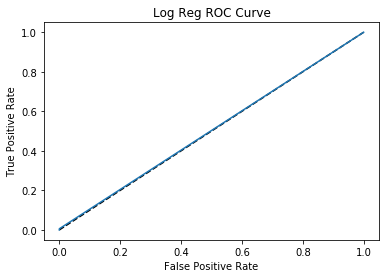

In [63]:
plt.plot([0,1],[0,1],'k--');
plt.plot(fpr,tpr, label='Log Reg');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Log Reg ROC Curve');

def scoring(estimator,X,y):
    '''Scoring function that returns % true predicitons that a user read the book'''
    confusion = confusion_matrix(y,estimator.predict(X))
    true_notread, false_notread, false_read, true_read = confusion.ravel()
    return true_read/(true_read+false_read)

#Logistic Regression
params = {'C':np.linspace(1,100,100,dtype=np.int),'tol':np.linspace(.0001,1,100)}

lrgrid = RandomizedSearchCV(lr,param_distributions=params,n_iter=5,n_jobs=-1,scoring=scoring)
lrgrid.fit(X,y)

best_c = lrgrid.best_params_['C']
best_tol = lrgrid.best_params_['tol']
print('Log Reg Grid Search')
print('Best log reg grid search score: {:.4f}'.format(lrgrid.best_score_))
print('Best C: {} - Best tol: {}'.format(best_c,best_tol),end='\n\n')

lr = LogisticRegression(C=best_c, tol=best_tol)
lr.fit(X,y)

ypred = lr.predict(X)
confusion = confusion_matrix(y,ypred)
true_notread, false_notread, false_read, true_read = confusion.ravel()

print('Log Reg Classifier Confusion Matrix')
print('Predicted {:.1f}% of read books as read'.format(true_read/(true_read+false_read)*100))
print('Predicted {:.1f}% of read books as unread'.format(false_read/(true_read+false_read)*100))
print('Predicted {:.1f}% of unread books as read'.format(false_notread/(false_notread+true_notread)*100))
print('Predicted {:.1f}% of unread books as unread'.format(true_notread/(true_notread+false_notread)*100))
pd.crosstab(y,ypred, rownames=['True'], colnames=['Predicted'],)

<h2>Logistic regression over predicts books that are not purchased/read as not purchased/read. With our goal being to recommend the books that users would want to buy, we need to maximize that metric.</h2><br>
<h2>Next, we'll try a random forest classifier</h2>

In [83]:
#RANDOM FOREST CLASSIFIER
def scoring(model,x,y):
    y_pred = model.predict(x)
    return precision_score(y,y_pred,pos_label=1)

params = {'n_estimators':np.linspace(1,100,1000,dtype=np.int),'criterion':['gini','entropy']}
rfc = RandomForestClassifier()
rfcgrid = RandomizedSearchCV(rfc,params,scoring=scoring,n_iter=10,n_jobs=-1)
rfcgrid.fit(X,y)

best__n_estimators = rfcgrid.best_params_['n_estimators']
best__criterion = rfcgrid.best_params_['criterion']
print('Random Forests Grid Search')

print('Best Random Forests grid search score: {:.4f}'.format(rfcgrid.best_score_))
print('Best n_estimators: {:.4f} - Best Criterion: {}'.format(best__n_estimators,best__criterion),end='\n\n')

Random Forests Grid Search
Best Random Forests grid search score: 0.0096
Best n_estimators: 38.0000 - Best Criterion: gini



In [84]:
rfc = RandomForestClassifier(n_estimators=50,criterion='gini',n_jobs=-1)
rfc.fit(X,y)

y_pred = rfc.predict(X)
y_pred_proba = rfc.predict_proba(X)[:,1]
fpr,tpr,thresholds = roc_curve(y,y_pred)

In [85]:
print('Random Forests Confusion Matrix\n')
print(pd.crosstab(y,y_pred, rownames=['True'], colnames=['Predicted'],))

Random Forests Confusion Matrix

Predicted      0.0   1.0
True                    
0.0        2514203   141
1.0           8493  4944


In [86]:
print('Random Forests Classification Report\n')
print(classification_report(y,y_pred,target_names=['Not Read','Read']))

Random Forests Classification Report

             precision    recall  f1-score   support

   Not Read       1.00      1.00      1.00   2514344
       Read       0.97      0.37      0.53     13437

avg / total       1.00      1.00      1.00   2527781



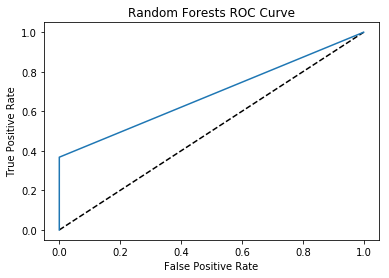

In [87]:
plt.plot([0,1],[0,1],'k--');
plt.plot(fpr,tpr, label='Random Forests');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Random Forests ROC Curve');

In [88]:
print('Feature Importancs\n')
print(pd.Series(rfc.feature_importances_,X.columns).sort_values(ascending=False))

Feature Importancs

cosines                    0.464504
avg_cosine                 0.457226
ratings                    0.020133
avg_rating                 0.017787
avg_explicit_rating        0.016437
user_count                 0.011296
explicit_implicit_ratio    0.007958
implicit_ratings           0.004659
dtype: float64


In [89]:
def recommender(model,usr):
    user_recommendations = collab_filter_recommendations(usr)
    
    if len(user_recommendations) > 0:
        X_sample = user_recommendations.drop(['read'],axis=1)
        user_recommendations['predicted'] = model.predict(X_sample)
        return user_recommendations.sort_values(['predicted','cosines'],ascending=False)[:10]
    
    return "No Recommendations"

In [90]:
selected_user = 278418
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
278418 0515126772         3.8                  9.5    0.055296   
       0446604275         0.0                  0.0    0.056385   
       0440236673         5.0                  7.5    0.048459   
       0590568892         0.0                  0.0    0.049929   
       0743406176         4.5                  9.0    0.049372   
       0451205421         7.5                  7.5    0.048103   
       0380702843         0.0                  0.0    0.047484   
       0590494457        10.0                 10.0    0.092841   
       0446605239         5.0                 10.0    0.044122   
       0440214041         3.5                  7.0    0.038437   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
278418 0515126772                 0.666667         5.0  0.276481     19.0   
       0446604275                 0.000000         3.0  0.169155      0.0   
       0440236673                 2.000000         3.0  0.145378     15.0   
       0590568892                 0.000000         2.0  0.099859      0.0   
       0743406176                 1.000000         2.0  0.098745      9.0   
       0451205421                 0.000000         2.0  0.096205     15.0   
       0380702843                 0.000000         2.0  0.094968      0.0   
       0590494457                 0.000000         1.0  0.092841     10.0   
       0446605239                 1.000000         2.0  0.088244     10.0   
       0440214041                 1.000000         2.0  0.076873      7.0   

                   implicit_ratings  read  predicted  
user   ISBN                                           
278418 0515126772               3.0   1.0        1.0  
       0446604275               3.0   1.0        1.0  
       0440236673               1.0   1.0        1.0  
       0590568892               2.0   1.0        1.0  
       0743406176               1.0   1.0        1.0  
       0451205421               0.0   1.0        1.0  
       0380702843               2.0   1.0        1.0  
       0590494457               0.0   1.0        1.0  
       0446605239               1.0   1.0        1.0  
       0440214041               1.0   1.0        1.0

In [91]:
selected_user = 111422
res = recommender(rfc,selected_user)
res

'No Recommendations'

In [92]:
selected_user = 35859
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user  ISBN                                                      
35859 0312980140    6.800000                  8.5    0.054018   
      0446610038    2.000000                 10.0    0.042775   
      0439064872    4.500000                  9.0    0.047471   
      0609804138    5.666667                  8.5    0.053363   
      0312983867    2.666667                  8.0    0.051698   
      0425182908    1.666667                  5.0    0.048854   
      0142001740    5.666667                  8.5    0.047589   
      1400034779    3.000000                  9.0    0.046064   
      0312955006    2.333333                  7.0    0.042922   
      0441304834    0.000000                  0.0    0.058316   

                  explicit_implicit_ratio  user_count   cosines  ratings  \
user  ISBN                                                                 
35859 0312980140                     4.00         5.0  0.270089     34.0   
      0446610038                     0.25         5.0  0.213873     10.0   
      0439064872                     1.00         4.0  0.189884     18.0   
      0609804138                     2.00         3.0  0.160090     17.0   
      0312983867                     0.50         3.0  0.155094      8.0   
      0425182908                     0.50         3.0  0.146563      5.0   
      0142001740                     2.00         3.0  0.142766     17.0   
      1400034779                     0.50         3.0  0.138192      9.0   
      0312955006                     0.50         3.0  0.128765      7.0   
      0441304834                     0.00         2.0  0.116632      0.0   

                  implicit_ratings  read  predicted  
user  ISBN                                           
35859 0312980140               1.0   1.0        1.0  
      0446610038               4.0   1.0        1.0  
      0439064872               2.0   1.0        1.0  
      0609804138               1.0   1.0        1.0  
      0312983867               2.0   1.0        1.0  
      0425182908               2.0   1.0        1.0  
      0142001740               1.0   1.0        1.0  
      1400034779               2.0   1.0        1.0  
      0312955006               2.0   1.0        1.0  
      0441304834               2.0   1.0        1.0

In [108]:
selected_user = 153662
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
153662 0515116750    5.250000             7.875000    0.067149   
       0373243286    2.900000             7.250000    0.069144   
       0515127833    3.727273             8.200000    0.061176   
       0515122734    3.600000             7.200000    0.063602   
       0399148248    5.571429             7.800000    0.080349   
       0515135216    6.285714             7.333333    0.074783   
       0380812029    2.500000             5.000000    0.081719   
       0425173631    5.000000             8.000000    0.060880   
       0425148297    2.000000             4.666667    0.067734   
       0671001795    3.000000             8.000000    0.056079   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
153662 0515116750                 2.000000        12.0  0.805793     63.0   
       0373243286                 0.666667        10.0  0.691444     29.0   
       0515127833                 0.833333        11.0  0.672941     41.0   
       0515122734                 1.000000        10.0  0.636023     36.0   
       0399148248                 2.500000         7.0  0.562440     39.0   
       0515135216                 6.000000         7.0  0.523478     44.0   
       0380812029                 1.000000         6.0  0.490315     15.0   
       0425173631                 1.666667         8.0  0.487042     40.0   
       0425148297                 0.750000         7.0  0.474139     14.0   
       0671001795                 0.600000         8.0  0.448629     24.0   

                   implicit_ratings  read  predicted  
user   ISBN                                           
153662 0515116750               4.0   1.0        1.0  
       0373243286               6.0   1.0        1.0  
       0515127833               6.0   1.0        1.0  
       0515122734               5.0   1.0        1.0  
       0399148248               2.0   1.0        1.0  
       0515135216               1.0   1.0        1.0  
       0380812029               3.0   1.0        1.0  
       0425173631               3.0   1.0        1.0  
       0425148297               4.0   1.0        1.0  
       0671001795               5.0   1.0        1.0

In [109]:
selected_user = 73394
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user  ISBN                                                      
73394 0316666343    3.333333            10.000000    0.117654   
      0446672211    4.000000             8.000000    0.152064   
      0060928336    4.500000             9.000000    0.109484   
      0380718340    7.000000             7.000000    0.158043   
      0345435168    8.000000             8.000000    0.137182   
      0689850859    7.000000             7.000000    0.134563   
      0345339703    6.333333             7.600000    0.179537   
      0345339711    7.200000             9.000000    0.165519   
      0385504209    7.000000             9.333333    0.181865   
      0439064872    3.000000             9.000000    0.156774   

                  explicit_implicit_ratio  user_count   cosines  ratings  \
user  ISBN                                                                 
73394 0316666343                      0.5         3.0  0.352962     10.0   
      0446672211                      1.0         2.0  0.304127      8.0   
      0060928336                      1.0         2.0  0.218969      9.0   
      0380718340                      0.0         1.0  0.158043      7.0   
      0345435168                      0.0         1.0  0.137182      8.0   
      0689850859                      0.0         1.0  0.134563      7.0   
      0345339703                      5.0         6.0  1.077225     38.0   
      0345339711                      4.0         5.0  0.827595     36.0   
      0385504209                      3.0         4.0  0.727461     28.0   
      0439064872                      0.5         3.0  0.470323      9.0   

                  implicit_ratings  read  predicted  
user  ISBN                                           
73394 0316666343               2.0   1.0        1.0  
      0446672211               1.0   1.0        1.0  
      0060928336               1.0   1.0        1.0  
      0380718340               0.0   1.0        1.0  
      0345435168               0.0   1.0        1.0  
      0689850859               0.0   1.0        1.0  
      0345339703               1.0   0.0        0.0  
      0345339711               1.0   0.0        0.0  
      0385504209               1.0   0.0        0.0  
      0439064872               2.0   0.0        0.0

In [97]:
ratings_us_test['User-ID'].value_counts().head(25),ratings_us_test['User-ID'].value_counts().tail(10)

(35859     1005
 153662     968
 198711     923
 98391      760
 76352      615
 278418     585
 16795      510
 110973     483
 235105     465
 230522     453
 204864     431
 227447     426
 60244      417
 234623     410
 129358     391
 102967     390
 55492      385
 185233     378
 190925     376
 52584      375
 135149     375
 232131     373
 69697      369
 78783      367
 73394      362
 Name: User-ID, dtype: int64, 2395      1
 124684    1
 202514    1
 208661    1
 205118    1
 139059    1
 143157    1
 159549    1
 43279     1
 8188      1
 Name: User-ID, dtype: int64)

In [74]:
user_recommendations['predicted'] = rfc.predict(X_sample)
user_recommendations.sort_values('predicted',ascending=False)[:10]

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
278418 0440214041         3.5                  7.0    0.038437   
       0440236673         5.0                  7.5    0.048459   
       0449910237         7.0                  7.0    0.044769   
       0553573136         7.0                  7.0    0.044769   
       0451205421         7.5                  7.5    0.048103   
       0590568892         0.0                  0.0    0.049929   
       0380702843         0.0                  0.0    0.047484   
       0743406176         4.5                  9.0    0.049372   
       0446604275         0.0                  0.0    0.056385   
       0590494457        10.0                 10.0    0.092841   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
278418 0440214041                      1.0         2.0  0.076873      7.0   
       0440236673                      2.0         3.0  0.145378     15.0   
       0449910237                      0.0         1.0  0.044769      7.0   
       0553573136                      0.0         1.0  0.044769      7.0   
       0451205421                      0.0         2.0  0.096205     15.0   
       0590568892                      0.0         2.0  0.099859      0.0   
       0380702843                      0.0         2.0  0.094968      0.0   
       0743406176                      1.0         2.0  0.098745      9.0   
       0446604275                      0.0         3.0  0.169155      0.0   
       0590494457                      0.0         1.0  0.092841     10.0   

                   implicit_ratings  read  predicted  
user   ISBN                                           
278418 0440214041               1.0   1.0        1.0  
       0440236673               1.0   1.0        1.0  
       0449910237               0.0   0.0        1.0  
       0553573136               0.0   1.0        1.0  
       0451205421               0.0   1.0        1.0  
       0590568892               2.0   1.0        1.0  
       0380702843               2.0   1.0        1.0  
       0743406176               1.0   1.0        1.0  
       0446604275               3.0   1.0        1.0  
       0590494457               0.0   1.0        1.0

In [ ]:
111422

x = sorted(metrics)
n = len(x)
y = np.arange(1, n+1)/n

plt.plot(x,y);
plt.title('Median: {}'.format(np.median(metrics)));

<H1>DONT DELETE AFTER THIS. FOR BOOK SIMILARITIES</H1>

<h2>Create a book x book matrix with cosine similarities as their intersection values</h2>

In [ ]:
book_adj_matrix = user_adj_matrix.T
book_sims = cosine_similarity(book_adj_matrix,dense_output=False)
book_sims.setdiag(0)
book_sims_coo = book_sims.tocoo()

In [ ]:
def bk_mtx_ind(coo_mtx):
    '''Loop through coordinate matrix rows and store the idx location of values in a dictionary
       dict[row].append(idx) 
       
       This will allow for fast lookups later vs looping through a 300MM list thousands of times later
       
       Move complexity from O(n^2) to O(N) (iterate matrix rows once, N every lookup is O(1) in python dicts)
    '''  
    bk_mtx_lkup = defaultdict(list)
    
    for i,bk in enumerate(coo_mtx.row):
        bk_mtx_lkup[bk].append(i)
        
    return bk_mtx_lkup

b = dt.datetime.now()
bk_mtx_lkup = bk_mtx_ind(coo_mtx=book_sims_coo)
print(dt.datetime.now() - b)

In [83]:
def book_collab_filter(selected_user,node_list,book_matrix,book_matrix_lookup,top_n_similarities):
    
    def node_similiarities(nodes, node_list, matrix,book_matrix_lookup): #### O(n^2), can i reduce this?
        '''Creates a numpy array of node similiarities (user or books)'''
        nodes_sim = defaultdict(list)
        
        # find the positions of all the books read by the user
        book_positions = np.where(np.isin(node_list,nodes))[0]
        
        #For each data point from node, append value book to dictionary key cosine similarity
        for i,pos in enumerate(book_positions):
            for idx in book_matrix_lookup[pos]:
                bk = node_list[matrix.col[idx]]
                if not bk in nodes:
                    nodes_sim[matrix.data[idx]].append(bk)
                
        return nodes_sim
    
    def user_neighbor_books(book_similarity_dict, top_n_similarities,user_read_books):
        '''accepts a 2d array with users in the first column and similarities in the 2nd
           returns top 10 books with scores'''
        books = defaultdict(lambda: defaultdict(float))
        for key in sorted(book_similarity_dict.keys(),reverse=True)[:top_n_similarities]:
            for bk in book_similarity_dict[key]:
                if not bk in user_read_books:
                    books[bk]['count'] += 1
                    books[bk]['cosine'] += key
                    books[bk]['avg_cosine'] = books[bk]['cosine']/books[bk]['count']  
                    books[bk]['avg_rating'] = books[bk]['rating']/books[bk]['count']
        return books
    
    def books_dict_to_df(books_list):
        books_list = [(b,
               d['avg_rating'],        
               d['avg_cosine'],
               d['count'],
               d['cosine']) for b,d in zip(book_books_df.keys(),book_books_df.values())]
        df_columns = ['book','avg_rating','avg_cosine','book_count','cosines']
        return pd.DataFrame(books_list,columns=df_columns)
    
    ## return top cosine similarities books based on books user read
    
    ## For books user read
        # Get books with high cosine similarities to each book
        # count and store in dict/data frame

    ### GET BOOK LIST
    dfa = defaultdict(list)
    user_read_books = set(G.neighbors(selected_user))
    for x in list(user_read_books):
        dfa[G[selected_user][x]['Book-Rating']].append(x)  
        
    top_5_keys = sorted(dfa.keys())[-1::]
    top_5_rated_books = []
    for x in top_5_keys:
        top_5_rated_books += dfa[x]
    
    
    book_sims_nodes = node_similiarities(np.array(top_5_rated_books),node_list,book_matrix,book_matrix_lookup)
    
    book_books_df = user_neighbor_books(book_similarity_dict=book_sims_nodes,
                                        top_n_similarities=top_n_similarities,user_read_books=user_read_books)
    
    return books_dict_to_df(book_books_df).set_index('book')

In [84]:
len(list(G.neighbors(selected_user)))

3896

In [94]:
selected_user = 153662
res = book_collab_filter(selected_user,books_arr,book_sims_coo,bk_mtx_lkup,20)

In [95]:
# Pull actual purchases
sel_user_actual = ratings_us_test[ratings_us_test['User-ID']==selected_user]['ISBN'].to_frame()
sel_user_actual['read'] = 1

In [98]:
# TOP N Recommendation based on cosines
n_recommendations = 15
reco_test = res.sort_values(['book_count','avg_cosine'],ascending=False).head(n_recommendations).join(sel_user_actual.set_index('ISBN'))
reco_test

,avg_rating,avg_cosine,book_count,cosines,read
book,,,,,
0505524236,0.0,0.724476,2.0,1.448952,NaN
0671737694,0.0,0.707107,2.0,1.414214,NaN
0874062853,0.0,0.707107,2.0,1.414214,NaN
0671535307,0.0,0.707107,2.0,1.414214,NaN
8440629583,0.0,0.707107,2.0,1.414214,NaN
0831713097,0.0,0.707107,2.0,1.414214,NaN
0590414151,0.0,0.707107,2.0,1.414214,NaN
1569870454,0.0,0.707107,2.0,1.414214,NaN
1570825181,0.0,0.707107,2.0,1.414214,NaN


False

In [ ]:
top_n_cosines = 50 
n_recommendations = 15
test_ratings_user_count = 50

test_ratings_user_valcount = ratings_us_test['User-ID'].value_counts()
filtered_test_ratings = test_ratings_user_valcount[test_ratings_user_valcount>test_ratings_user_count]
users_to_test = filtered_test_ratings.index.values

metrics = np.empty(len(users_to_test))

for i,sel_user in enumerate(users_to_test):
    recommended_books = collaborative_filter(sel_user,user_arr,user_sims_coo,top_n_cosines)
    sel_user_actual = ratings_us_test[ratings_us_test['User-ID']==sel_user]['ISBN'].to_frame()
    sel_user_actual['read'] = 1
    reco_test = recommended_books.sort_values(['cosines','avg_rating'],ascending=False).head(n_recommendations).join(sel_user_actual.set_index('ISBN'))
    metrics[i] = np.sum(reco_test['read'])/n_recommendations

In [ ]:
def user_book_cosines(usr):
    read_books = list(G[usr])
    books = defaultdict(lambda: defaultdict(float))
    for bk in read_books:
        book_nodes,book_scores = node_similiarities(bk,books_arr,book_sims_coo)
        for book,score in zip(book_nodes,book_scores):
            books[book]['cosine_total'] +=score
            books[book]['count'] += 1
            books[book]['avg_cosine'] = books[book]['cosine_total']/books[book]['count']
        
    return books

book_list = user_book_cosines(selected_user)
book_list = [(b,
               d['cosine_total'],
               d['count'],
               d['avg_cosine']) for b,d in zip(book_list.keys(),book_list.values())]
book_book_df = pd.DataFrame(book_list,columns=['book','book_book_cosine','book_book_count','book_book_avgcosine'])
book_book_df.sort_values('book_book_count',ascending=False,inplace=True)
book_book_df.set_index('book',inplace=True)


In [ ]:
list(G[selected_user])[0]

In [ ]:
list(G.neighbors('034542252'))

In [ ]:
len(list(G.neighbors(166409)))

In [ ]:
user_scores[user_scores>np.percentile(user_scores,1)]

In [ ]:
book_reco

<h2>Build books into dataframe</h2>

In [ ]:
book_book_df.head()

In [ ]:
tst = book_reco.join(book_book_df,how='outer')

np.percentile(tst['avg_user_cosines'].fillna(0),99.9) #book_book_avgcosine, #avg_user_cosines

In [ ]:
sel_user_actual = ratings_us_test[ratings_us_test['User-ID']==selected_user]['ISBN'].to_frame()
sel_user_actual['read'] = 1
tst1 = tst.join(sel_user_actual.set_index('ISBN'),how='outer')
np.sum(tst1['read']>0)/len(tst1)

In [ ]:

tst1['book_book_avgcosine'].hist()

In [ ]:
tst1['avg_user_cosines'].hist()

In [ ]:
ratings_df['User-ID'].value_counts()[ratings_df['User-ID'].value_counts()<3].sum()/len(ratings_df['User-ID'].unique())

In [ ]:
ratings_us_test['User-ID'].unique()

In [ ]:
book_reco_filtered = book_reco[book_reco['user_count'] >= 10]
book_reco_filtered['avg_user_cosine'] = book_reco_filtered['user_cosines']/book_reco_filtered['user_count']
top_10_books = set(book_reco_filtered.sort_values('avg_user_cosine',ascending=False).iloc[:10]['book'])
top_10_books.intersection(set(ratings_us_test[ratings_us_test['User-ID']==selected_user].sort_values('ISBN')['ISBN']))
#top_10_books